In [1]:
%load_ext autoreload
%autoreload 2

import sys
#sys.path.insert(0, '.benchmarks/iir/')

In [2]:
import array

from simplefilters import butter2_lowpass, butter2_highpass, butter2_bandpass

import scipy.signal
from matplotlib import pyplot as plt

import numpy
import pandas
import librosa
import seaborn

low2.scipy
[[ 0.02008337  0.04016673  0.02008337  1.         -1.56101808  0.64135154]]
low2.simple
[[0.020083365564211236, 0.04016673112842247, 0.020083365564211236, 1.0, -1.5610180758007182, 0.6413515380575631]]
high2.scipy
[[ 0.8005924  -1.60118481  0.8005924   1.         -1.56101808  0.64135154]]
high2.simple
[[0.8005924034645703, -1.6011848069291406, 0.8005924034645703, 1.0, -1.5610180758007182, 0.6413515380575631]]


/tmp/ipykernel_27591/4127207659.py:11: RuntimeWarning: divide by zero encountered in log10
  db = 20 * numpy.log10(abs(h))


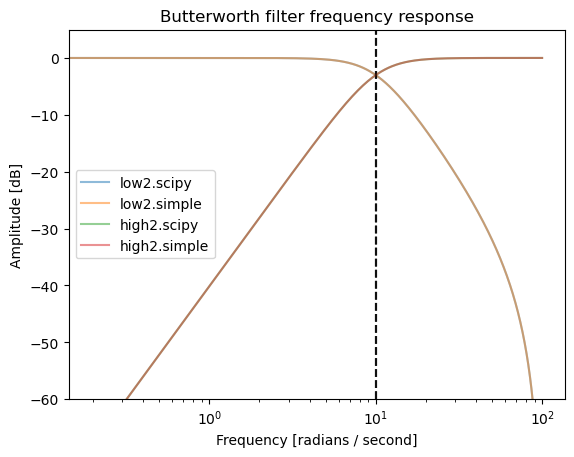

In [174]:



def scipy_butter_lowpass(order, cutoff, fs, output='sos'):
    return scipy.signal.butter(N=order, Wn=cutoff, btype='low', analog=False, output=output, fs=fs)

def scipy_butter_highpass(order, cutoff, fs, output='sos'):
    return scipy.signal.butter(N=order, Wn=cutoff, btype='high', analog=False, output=output, fs=fs)

def plot_frequency_response(ax, sos, fs, cutoff=None, label=None, alpha=1.0):
    
    w, h = scipy.signal.sosfreqz(sos, fs=fs)

    db = 20 * numpy.log10(abs(h))

    ax.semilogx(w, db, label=label, alpha=alpha)   
    ax.set_title('Butterworth filter frequency response')
    ax.set_xlabel('Frequency [radians / second]')
    ax.set_ylabel('Amplitude [dB]')
    #ax.set_margins(0, 0.1)
    
    ax.grid(which='both', axis='both')
    if cutoff is not None:
        ax.axvline(cutoff, color='black', alpha=0.5, ls='--') # cutoff frequency
    
    return ax

fs = 200
cutoff = 10

filters = {
    'low2.scipy': scipy_butter_lowpass(2, cutoff, fs=fs),
    'low2.simple': [ butter2_lowpass(cutoff, fs) ],
    'high2.scipy': scipy_butter_highpass(2, cutoff, fs=fs),
    'high2.simple': [ butter2_highpass(cutoff, fs) ],
}

fig, ax = plt.subplots(1)
for name, coeff in filters.items():
    print(name)
    print(coeff)
    plot_frequency_response(ax, sos=coeff, fs=fs, cutoff=cutoff, label=name, alpha=0.5)
    ax.set_ylim(-60, 5)
    ax.legend()


array('i', [26233, 0, -52466, 26233, -51149, 21015])

[[ 0.04125354  0.08250707  0.04125354  1.         -1.36336213  0.60616707]
 [ 1.         -2.          1.          1.         -1.81859845  0.84792118]]
[[ 0.89485861 -1.78971721  0.89485861  1.         -1.77863178  0.80080265]
 [ 0.06745527  0.13491055  0.06745527  1.         -1.1429805   0.4128016 ]]


/tmp/ipykernel_27591/4127207659.py:11: RuntimeWarning: divide by zero encountered in log10
  db = 20 * numpy.log10(abs(h))


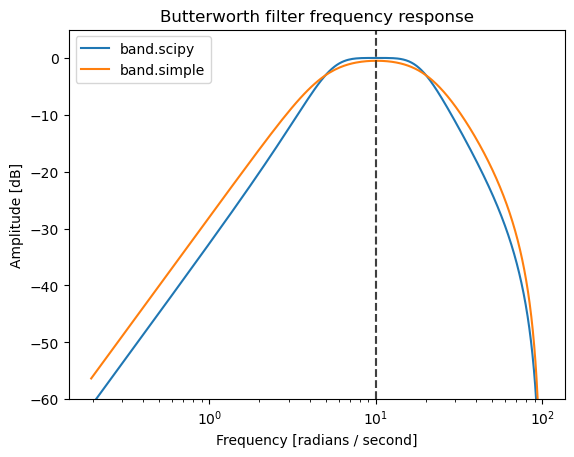

In [6]:


fs = 200
low = 5
high = 20

filters = {
    'band.scipy':  scipy.signal.butter(N=2, Wn=(low, high), btype='bandpass', analog=False, output='sos', fs=fs),
    'band.simple': numpy.array(butter2_bandpass(low, high, fs)).reshape(-1, 6),
}

fig, ax = plt.subplots(1)
for name, coeff in filters.items():
    #print(name)
    print(coeff)
    plot_frequency_response(ax, sos=coeff, fs=fs, cutoff=cutoff, label=name)
    ax.set_ylim(-60, 5)
    ax.legend()


run:  micropython /home/jon/projects/emlearn-micropython/benchmarks/iir/iir_run.py /tmp/tmp7ijt16bs/input.npy /tmp/tmp7ijt16bs/output.npy /tmp/tmp7ijt16bs/filter.npy
out
c (6,) array('f', [0.8005924224853516, -1.601184844970703, 0.8005924224853516, 1.0, -1.561018109321594, 0.6413515210151672])
r /tmp/tmp7ijt16bs/input.npy 8080 (2000,) f 4



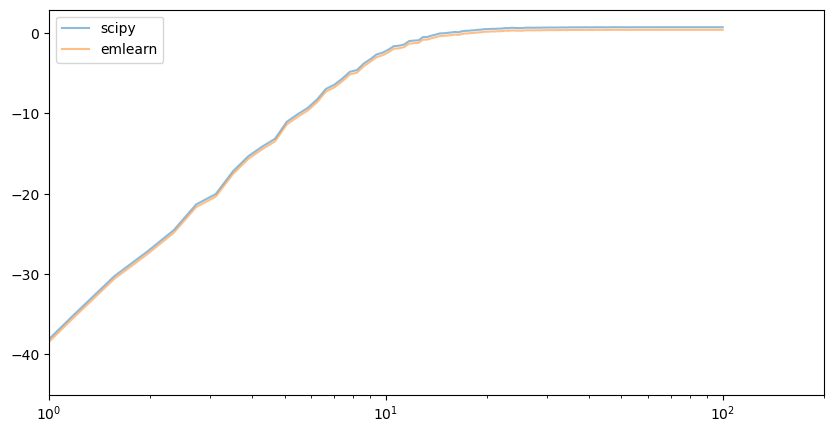

In [175]:

def spectrum_welch(signal, sr, n_fft, window='hann'):
    freqs, power = scipy.signal.welch(signal, fs=sr, nperseg=n_fft, window=window, scaling="spectrum", average='mean')
    db = librosa.power_to_db(power, ref=0.0, top_db=240)
    return pandas.Series(db, index=freqs)


def plot_spectrum_difference(ax, input, output, fs, label=None, alpha=0.5, n_fft = 512):
    
    S_in = spectrum_welch(input, sr=fs, n_fft=n_fft)
    S_out = spectrum_welch(output, sr=fs, n_fft=n_fft)
    
    FR = S_out - S_in
    FR += numpy.random.random(1)
    ax.plot(FR.index, FR.values, label=label, alpha=alpha)
    ax.set_xscale('log')
    ax.set_xlim(1, fs)

def sosfilt_emlearn(coeff : numpy.array, input : numpy.array):
    """
    Calls MicroPython in a subprocess, using eml_iir modules from emlearn-micropython
    """
    from iir_run_subprocess import run_iir
    
    out = run_iir(array.array('f', input), array.array('f', coeff.flatten()))

    out = numpy.array(out)
    
    return out


noise = numpy.random.random(2000)
out_scipy = scipy.signal.sosfilt(coeff, noise)
out_emlearn = sosfilt_emlearn(numpy.array(coeff), noise)

fig, ax = plt.subplots(1, figsize=(10, 5))
plot_spectrum_difference(ax, noise, out_scipy, fs=fs, label='scipy')
plot_spectrum_difference(ax, noise, out_emlearn, fs=fs, label='emlearn')
ax.legend()


c [ 0.8005924  -1.60118481  0.8005924   1.         -1.56101808  0.64135154]
o array('i', [6557, 0, -13115, 6557, 12786, -5253])
run:  micropython /home/jon/projects/emlearn-micropython/benchmarks/iir/iir_run.py /tmp/tmp9i1jx9mq/input.npy /tmp/tmp9i1jx9mq/output.npy /tmp/tmp9i1jx9mq/filter.npy
out
c (6,) array('h', [6557, 0, -13115, 6557, 12786, -5253])
r /tmp/tmp9i1jx9mq/input.npy 4080 (2000,) h 2



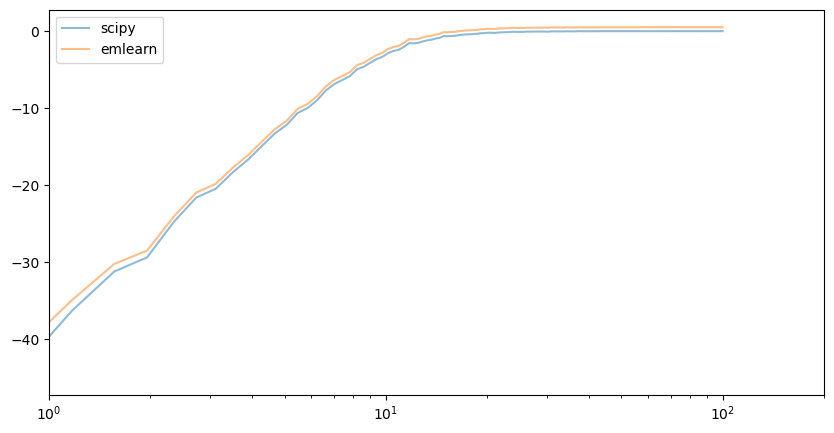

In [178]:

def convert_coefficients_q15(c, scale):
    out = array.array('i', (0 for _ in range(len(c))))
    assert (len(c) % 6 == 0), len(c)
    n_stages = len(c) // 6
    
    # Transposed Direct Form II / sosfilt / emliir
    # [ b0, b1, b2, 1.0, -a1, -a2 ]
    # Direct Form I / eml_iir_q15 
    # [ b0, 0, b1, b2, a1, a2 ]

    # NOTE: in CMSIS-DSP the “a” coefficients are negative compared to the SciPy conventions
    for stage in range(n_stages):
        offset = stage*6
        b0, b1, b2, a0, a1, a2 = c[offset:offset+6]
        assert a0 == 1.0
        out[offset+0] = int(b0 * scale)
        out[offset+1] = 0
        out[offset+2] = int(b1 * scale)
        out[offset+3] = int(b2 * scale)
        out[offset+4] = int(-a1 * scale)
        out[offset+5] = int(-a2 * scale)

    print('c', c)
    print('o', out)
    return out


def sosfilt_emlearn_q15(coeff : numpy.array, input : numpy.array):
    """
    Calls MicroPython in a subprocess, using eml_iir modules from emlearn-micropython
    """
    from iir_run_subprocess import run_iir

    scale = (2**13)-1

    coeff_q15 = convert_coefficients_q15(coeff.flatten(), scale)
    input_q15 = (input * 2**15).astype(numpy.int16)
    
    out = run_iir(array.array('h', input_q15), array.array('h', coeff_q15))

    out = numpy.array(out).astype(float) / (2**15)
    
    return out

# in CMSIS-DSP the “a” coefficients are negative compared to the SciPy conventions.
# Since the coefficients were scaled down by 4, we need to set the postshift to 2 
# https://developer.arm.com/documentation/102463/0100/How-to-implement-biquads-to-filter-an-Electrocardiography-signal

#coeff = [ [ 0.25, 0.0, 0.0, 1.0, 0.0, 0.0 ] ]

noise = numpy.random.random(2000) - 0.5
out_scipy = scipy.signal.sosfilt(coeff, noise)
out_emlearn = sosfilt_emlearn_q15(numpy.array(coeff), noise)

fig, ax = plt.subplots(1, figsize=(10, 5))
plot_spectrum_difference(ax, noise, out_scipy, fs=fs, label='scipy')
plot_spectrum_difference(ax, noise, out_emlearn, fs=fs, label='emlearn')
ax.legend()
